In [2]:
# default_exp spatialjoin_highest_intersection

In [3]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq geowrangler
! [ -e /content ] && pip install -Uqq git+https://github.com/butchland/nbdev.git@add-black-format
# downgrade tornado if in colab
! [ -e /content ] && pip install -Uqq tornado==5.1.0

In [4]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
# hide
import warnings

from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings(action="ignore", category=UserWarning, module="geopandas")
warnings.filterwarnings(
    action="ignore", category=ShapelyDeprecationWarning, module="pandas"
)

# Spatial Join Highest Intersection


# Import

In [6]:
# export
import json
import os
import geopandas as gpd
import pandas as pd
import requests
from geowrangler import grids

# Generate Test Data

# Load a sample admin boundary file using geopandas

In [7]:
# hide
# Query geoBoundaries
def get_geoboundaries(filename, iso, adm):
    r = requests.get(
        "https://www.geoboundaries.org/gbRequest.html?ISO={}&ADM={}".format(iso, adm)
    )
    dl_path = r.json()[0]["gjDownloadURL"]

    # Save the result as a GeoJSON
    # filename = "../data/geoboundary.geojson"
    admin_bounds = requests.get(dl_path).json()
    with open(filename, "w") as file:
        json.dump(admin_bounds, file)

    # Read data using GeoPandas
    admin_bounds_gdf = gpd.read_file(filename)
    print("Data dimensions: {}".format(admin_bounds_gdf.shape))

In [8]:
# hide

ISO = "PHL"  # "PHL" is the ISO code for Philippines
ADM = "ADM2"  # Equivalent to administrative districts

In [9]:
# hide
# get_geoboundaries('../data/geoboundary.geojson',ISO,ADM)

In [10]:
admin_bounds_gdf = gpd.read_file("../data/geoboundary.geojson")

In [11]:
admin_bounds_gdf.head(3)

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Abra,None,PHL-ADM2-3_0_0-B1,PHL,ADM2,"MULTIPOLYGON (((120.96795 17.95706, 120.97803 ..."
1,Agusan del Norte,None,PHL-ADM2-3_0_0-B2,PHL,ADM2,"MULTIPOLYGON (((125.57724 9.45679, 125.59687 9..."
2,Agusan del Sur,None,PHL-ADM2-3_0_0-B3,PHL,ADM2,"MULTIPOLYGON (((125.91087 8.85625, 125.91461 8..."


In [12]:
admin_bounds_gdf.dtypes

shapeName       object
shapeISO        object
shapeID         object
shapeGroup      object
shapeType       object
geometry      geometry
dtype: object

In [13]:
# admin_bounds_gdf.explore()

# Generate a sample grid 

In [14]:
grid_generator5k = grids.SquareGridGenerator(50_000)  # 5 km x 5 km square cells

In [15]:
%%time
# slow
grid_gdf = grid_generator5k.generate_grid(admin_bounds_gdf)

CPU times: user 14.1 s, sys: 121 ms, total: 14.3 s
Wall time: 14.3 s


<AxesSubplot:>

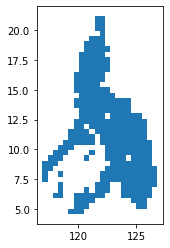

In [16]:
grid_gdf.plot()

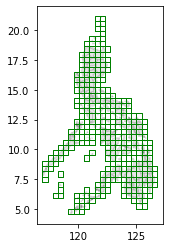

In [17]:
ax = admin_bounds_gdf.plot(facecolor="grey", edgecolor="grey", alpha=0.2)
ax = grid_gdf.plot(ax=ax, facecolor="none", edgecolor="green")

In [18]:
grid_gdf.describe()

,x,y
count,323.000000,323.000000
mean,11.773994,15.018576
std,4.861594,8.791210
min,0.000000,0.000000
25%,8.000000,8.000000
50%,11.000000,14.000000
75%,16.000000,21.000000
max,21.000000,37.000000


In [19]:
grid_gdf.head(3)

,x,y,geometry
0,5,0,"POLYGON ((119.17413 4.58694, 119.62328 4.58694..."
1,6,0,"POLYGON ((119.62328 4.58694, 120.07244 4.58694..."
2,7,0,"POLYGON ((120.07244 4.58694, 120.52160 4.58694..."


In [20]:
grid_gdf.dtypes

x              int64
y              int64
geometry    geometry
dtype: object

# Spatial join with highest intersection

In [26]:
# export
def get_highest_intersection(
    gdf1: gpd.GeoDataFrame,  # gdf1 will be the basis of output geometry
    gdf2: gpd.GeoDataFrame,  # gdf2 data will all be included during intersection
    proj_crs: str,  # metric CRS (e.g., Philippines uses EPSG:32651)
) -> gpd.GeoDataFrame:
    """Gets the intersection based on the largest area joined"""

    gdf1 = gdf1.copy()
    gdf2 = gdf2.copy()

    # renaming columns with __ prefixes and suffixes so they're less likely to be already used
    uid_col = "__uid__"
    area_col = "__area_highest_intersection__"
    auxiliary_cols = [uid_col, area_col]

    # checks to make sure we're not overwriting existing oclumns
    for col in auxiliary_cols:
        if col in gdf1.columns:
            raise ValueError(f"Make sure {col} isn't already a column in gdf1")
        if col in gdf2.columns:
            raise ValueError(f"Make sure {col} isn't already a column in gdf2")

    # assign uid to gdf1
    gdf1[uid_col] = range(len(gdf1))  # assign uid based on row number of first gdf

    # get intersection of the gdfs
    overlay = gdf1.overlay(gdf2, how="intersection")

    # add relevant columns
    overlay["geometry"] = overlay["geometry"].to_crs(
        proj_crs
    )  # geometry produced will be based on gdf1
    overlay[
        area_col
    ] = (
        overlay.geometry.area
    )  # shows area of overlap, not the area of the polygon in gdf1

    # sorting of values, dropping duplicates and null values
    overlay = overlay.sort_values(by=area_col, ascending=True)
    overlay = overlay.drop_duplicates(subset=[uid_col], keep="last")
    overlay = overlay.dropna(
        subset=[uid_col]
    )  # drops rows with value in gdf2 but has no info in gdf1
    assert not overlay[uid_col].duplicated().any()
    overlay = overlay.sort_values(by=[uid_col], ascending=True)

    # drop geometry from overlay gdf
    overlay_merge = overlay.drop(
        "geometry", axis=1
    )  # two geometries will be produced, drop overlay geometry

    output = pd.merge(
        left=gdf1[[uid_col, "geometry"]],
        right=overlay_merge,
        on=uid_col,
        how="left",
        validate="one_to_one",
    )

    output = output.drop(columns=auxiliary_cols)

    return output

In [22]:
get_highest_intersection(grid_gdf, admin_bounds_gdf, "EPSG:32651")

,geometry,x,y,shapeName,shapeISO,shapeID,shapeGroup,shapeType
0,"POLYGON ((119.17413 4.58694, 119.62328 4.58694...",5,0,Tawi-Tawi,None,PHL-ADM2-3_0_0-B77,PHL,ADM2
1,"POLYGON ((119.62328 4.58694, 120.07244 4.58694...",6,0,Tawi-Tawi,None,PHL-ADM2-3_0_0-B77,PHL,ADM2
2,"POLYGON ((120.07244 4.58694, 120.52160 4.58694...",7,0,Tawi-Tawi,None,PHL-ADM2-3_0_0-B77,PHL,ADM2
3,"POLYGON ((120.07244 5.03451, 120.52160 5.03451...",7,1,Tawi-Tawi,None,PHL-ADM2-3_0_0-B77,PHL,ADM2
4,"POLYGON ((119.62328 5.03451, 120.07244 5.03451...",6,1,Tawi-Tawi,None,PHL-ADM2-3_0_0-B77,PHL,ADM2
...,...,...,...,...,...,...,...,...
318,"POLYGON ((121.41991 19.89978, 121.86907 19.899...",10,35,Batanes,None,PHL-ADM2-3_0_0-B11,PHL,ADM2
319,"POLYGON ((121.41991 20.74217, 121.86907 20.742...",10,37,Batanes,None,PHL-ADM2-3_0_0-B11,PHL,ADM2
320,"POLYGON ((121.86907 20.74217, 122.31823 20.742...",11,37,Batanes,None,PHL-ADM2-3_0_0-B11,PHL,ADM2
321,"POLYGON ((121.41991 18.62778, 121.86907 18.627...",10,32,Cagayan,None,PHL-ADM2-3_0_0-B18,PHL,ADM2


# Check plot of output

In [23]:
output = get_highest_intersection(grid_gdf, admin_bounds_gdf, "EPSG:32651")

<AxesSubplot:>

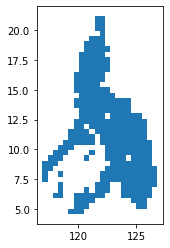

In [24]:
output.plot()

In [25]:
# output.explore()